In [4]:
# We set the environment variable to point to the folder where kaggle.json is saved
import os
os.environ["KAGGLE_CONFIG_DIR"]= os.environ["PWD"]

!kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images -p ./kaggle_Alzheimers_data/ --unzip

 94%|███████████████████████████████████▋  | 32.0M/34.1M [00:02<00:00, 22.3MB/s]
100%|██████████████████████████████████████| 34.1M/34.1M [00:02<00:00, 16.5MB/s]


In [5]:
!ls "./kaggle_Alzheimers_data/Alzheimer_s Dataset/"{test,train}

./kaggle_Alzheimers_data/Alzheimer_s Dataset/test:
MildDemented     ModerateDemented NonDemented      VeryMildDemented

./kaggle_Alzheimers_data/Alzheimer_s Dataset/train:
MildDemented     ModerateDemented NonDemented      VeryMildDemented


In [6]:
!ls "./kaggle_Alzheimers_data/Alzheimer_s Dataset/"{test,train}/MildDemented/

./kaggle_Alzheimers_data/Alzheimer_s Dataset/test/MildDemented/:
26 (19).jpg 27 (28).jpg 28 (4).jpg  29 (6).jpg  30 (8).jpg  31.jpg
26 (20).jpg 27 (3).jpg  28 (5).jpg  29 (7).jpg  30 (9).jpg  32 (10).jpg
26 (21).jpg 27 (4).jpg  28 (6).jpg  29 (8).jpg  30.jpg      32 (11).jpg
26 (22).jpg 27 (5).jpg  28 (7).jpg  29 (9).jpg  31 (10).jpg 32 (12).jpg
26 (23).jpg 27 (6).jpg  28 (8).jpg  29.jpg      31 (11).jpg 32 (13).jpg
26 (24).jpg 27 (7).jpg  28 (9).jpg  30 (10).jpg 31 (12).jpg 32 (14).jpg
26 (25).jpg 27 (8).jpg  28.jpg      30 (11).jpg 31 (13).jpg 32 (15).jpg
26 (26).jpg 27 (9).jpg  29 (10).jpg 30 (12).jpg 31 (14).jpg 32 (16).jpg
26 (27).jpg 27.jpg      29 (11).jpg 30 (13).jpg 31 (15).jpg 32 (17).jpg
26 (28).jpg 28 (10).jpg 29 (12).jpg 30 (14).jpg 31 (16).jpg 32 (18).jpg
26.jpg      28 (11).jpg 29 (13).jpg 30 (15).jpg 31 (17).jpg 32 (19).jpg
27 (10).jpg 28 (12).jpg 29 (14).jpg 30 (16).jpg 31 (18).jpg 32 (2).jpg
27 (11).jpg 28 (13).jpg 29 (15).jpg 30 (17).jpg 31 (19).jpg 32 (20).jpg
27 (1

In [7]:
!for d in "./kaggle_Alzheimers_data/Alzheimer_s Dataset/"{test,train}/* ; do echo "${d/.*Dataset\//}" $(ls "${d}" | wc -l ) ; done

test/MildDemented 179
test/ModerateDemented 12
test/NonDemented 640
test/VeryMildDemented 448
train/MildDemented 717
train/ModerateDemented 52
train/NonDemented 2560
train/VeryMildDemented 1792


Let us have a look at one of the images.

(208, 176, 3)


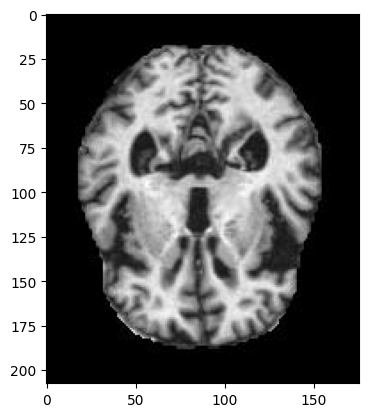

In [10]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("./kaggle_Alzheimers_data/Alzheimer_s Dataset/train/MildDemented/mildDem1.jpg")[:, :, ::-1]
plt.imshow(img)
print(img.shape)

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

BATCH_SIZE = 16
IMAGE_SIZE = [176, 208]
SEED = 1

trainDataLoc = "./kaggle_Alzheimers_data/Alzheimer_s Dataset/train"

# Creating the training dataset (keeping 20% for validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainDataLoc,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Creating the validation dataset (note: important to keep the same seed)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainDataLoc,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = len(train_ds.class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Let's look at a few more images and their categorisation.

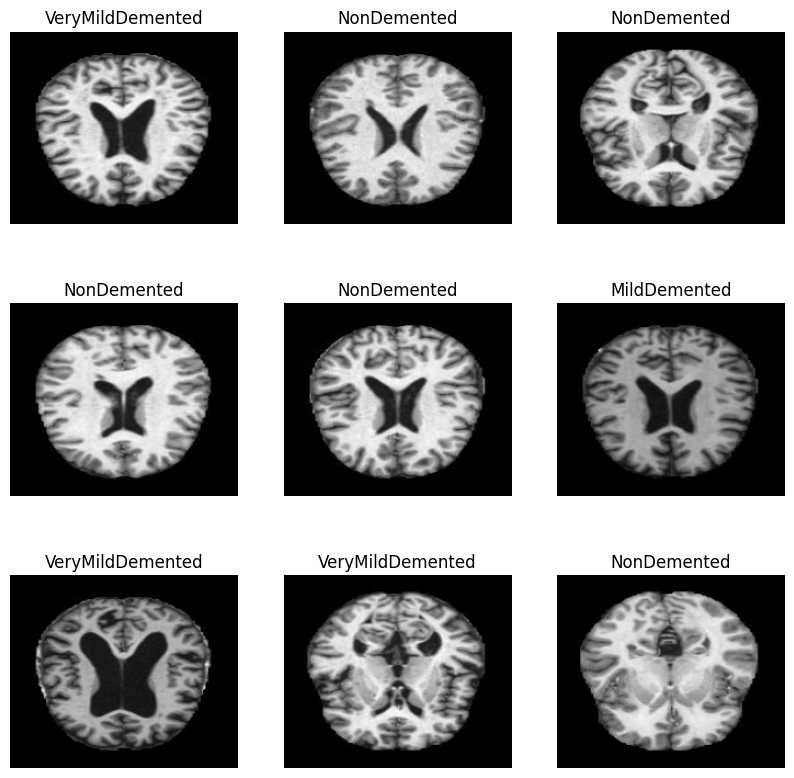

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Because we use categorical data, we switch to one-hot encoding

In [15]:
train_ds = train_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)

Before we proceed, let's try to find out how many images of each kind we have.

In [16]:
NUM_IMAGES = []
import os
for label in class_names:
    dir_name = trainDataLoc + "/" + label[:-2] + 'ed' # This is a specificity of the folder names vs. labels
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

print(class_names)
print(NUM_IMAGES)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
[717, 52, 2560, 1792]


We see that the samples are **NOT balanced**. We'll have to keep this in mind.

Now let's build our model. We start by defining some helpers to avoid repeating lines.


Note that we're using [SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D) rather than `Conv2D` as previously as the former tends to be faster. You can find more information in this [blog post](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728). Feel free to try using standard `Conv2D` elements and compare.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 16)       0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

We compile our model, using two metrics: accuracy and AUC (or area under the curve). The AUC (Area under the curve) of the ROC (Receiver operating characteristic; default) or PR (Precision Recall) curves are quality measures of binary classifiers. Unlike the accuracy, and like cross-entropy losses, ROC-AUC and PR-AUC evaluate all the operational points of a model. For more information, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC).

In [23]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

Callbacks are used to run code at each step, for example to implement early stopping or to save the model at checkpoints. The file `./kaggle_Alzheimers_data/working/alzheimer_model.keras` will contain the model and can be used later to load a model from a file, to avoid having to retrain each time.

In [24]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./kaggle_Alzheimers_data/working/alzheimer_model.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

Let's train our model. If it takes too long, adjust the parameters of your model to speed it up. You can reduce the number of epochs, or adjust the early stopping callback conditions.

In [25]:
EPOCHS=20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/20
257/257 [==============================] - 130s 490ms/step - loss: 0.9950 - accuracy: 0.5087 - auc: 0.8086 - val_loss: 61.6555 - val_accuracy: 0.4951 - val_auc: 0.6639 - lr: 0.0100
Epoch 2/20
257/257 [==============================] - 135s 523ms/step - loss: 0.9858 - accuracy: 0.5314 - auc: 0.8129 - val_loss: 9.6113 - val_accuracy: 0.4971 - val_auc: 0.6706 - lr: 0.0089
Epoch 3/20
257/257 [==============================] - 137s 531ms/step - loss: 0.9470 - accuracy: 0.5399 - auc: 0.8262 - val_loss: 2.1970 - val_accuracy: 0.1436 - val_auc: 0.5523 - lr: 0.0079
Epoch 4/20
257/257 [==============================] - 141s 549ms/step - loss: 0.9522 - accuracy: 0.5243 - auc: 0.8204 - val_loss: 3.4697 - val_accuracy: 0.5020 - val_auc: 0.7156 - lr: 0.0071
Epoch 5/20
257/257 [==============================] - 142s 551ms/step - loss: 0.9414 - accuracy: 0.5394 - auc: 0.8251 - val_loss: 0.9807 - val_accuracy: 0.5303 - val_auc: 0.8318 - lr: 0.0063
Epoch 6/20
257/257 [========================

<Axes: >

<Figure size 1200x1000 with 0 Axes>

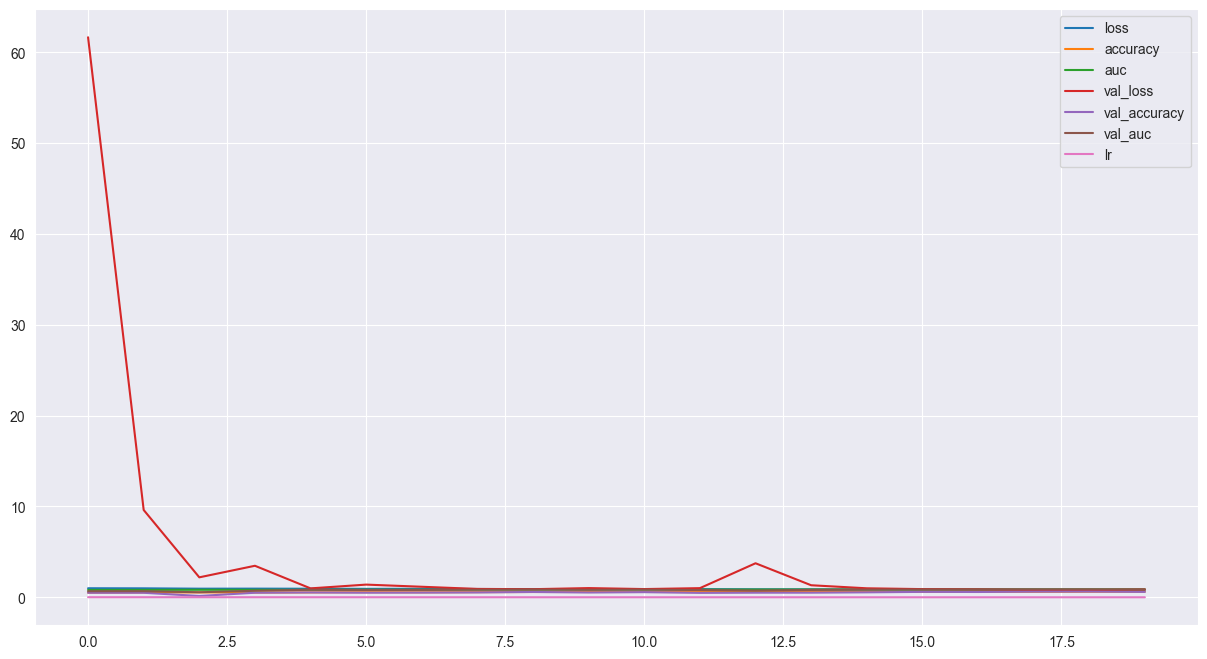

In [26]:
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
pd.DataFrame(model.history.history).plot(figsize=(15,8))

We can see that the acurracy never goes above 60%. (If you did check during an epoch, you'd see the accuracy go down.) 

You can also see that the performance doesn't impeove after a while: we could have probably run fewer epochs!!

We can probably do better. But first, we can look at the model's prediction.

In [27]:
# Importing the test dataset
testDataLoc = "./kaggle_Alzheimers_data/Alzheimer_s Dataset/test"

# Creating the training dataset (keeping 20% for validation)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDataLoc,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, NUM_CLASSES)), tf.data.experimental.AUTOTUNE)


Found 1279 files belonging to 4 classes.


In [28]:
model.evaluate(test_ds)

80/80 [==============================] - 8s 104ms/step - loss: 1.0898 - accuracy: 0.5450 - auc: 0.8281


[1.0898371934890747, 0.5449569821357727, 0.8280544281005859]

In [29]:
import numpy as np    
predicted_classes = model.predict(test_ds).argmax(axis=1)
test_classes = np.concatenate([y for x, y in test_ds], axis=0).argmax(axis=1)

80/80 [==============================] - 10s 116ms/step


Let us look at the confusion matrix.

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

cm = np.array(confusion_matrix(test_classes, predicted_classes, labels = [0, 1, 2, 3]))

confusion = pd.DataFrame(cm, index = class_names, columns = [class_names] )

confusion

MildDemented ModerateDemented NonDemented VeryMildDemented
MildDemented               11                0         150               18
ModerateDemented            0                0          11                1
NonDemented                22                0         537               81
VeryMildDemented           19                0         387               42

<Axes: xlabel='None'>

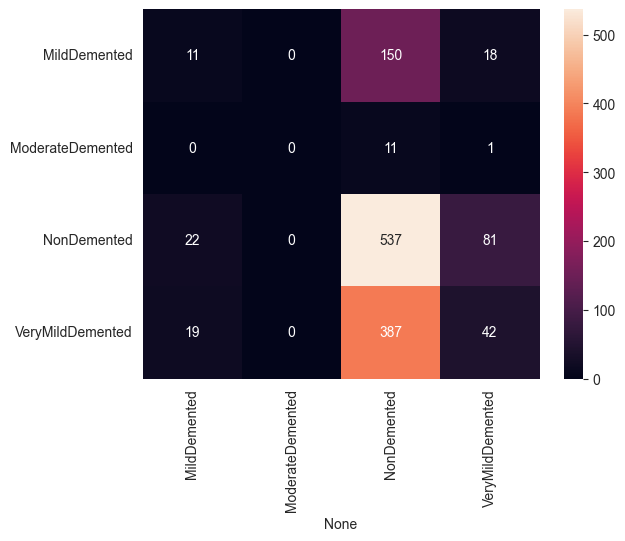

In [31]:
import seaborn as sns
sns.heatmap(confusion, annot=True, fmt='g')

We can see that the output is biased towards `NonDemented`. This is because it is the category with the most samples.

You can try to improve the classification by tweaking the network or playing with the number of items fed to the network for each category and see how it performs. Go have a look on Kaggle to see what others did.


Below is the gist of what you ned to train another model.

In [ ]:
# model2 = tf.keras.Sequential([
#     ...
# ])

# model2.summary()

# model2.compile(
#     optimizer=tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#     name='Adam'),
#     loss='categorical_crossentropy',
#     metrics=tf.keras.metrics.AUC(name='auc')
# )

# EPOCHS2=20

# history2 = model2.fit(
#     train_ds,
#     validation_data=val_ds,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
#     epochs=EPOCHS2
# )

# predicted_classes2 = model2.predict(test_ds).argmax(axis=1)

# cm2 = np.array(confusion_matrix(test_classes, predicted_classes2, labels = [0, 1, 2, 3]))

# confusion2 = pd.DataFrame(cm2, index = class_names, columns = [class_names] )

# confusion2